In [1]:
import ROOT

ROOT.gROOT.Macro('../setStyle.C')
ROOT.gROOT.LoadMacro('../FPCanvasStyle.C')

Welcome to JupyROOT 6.18/00


0

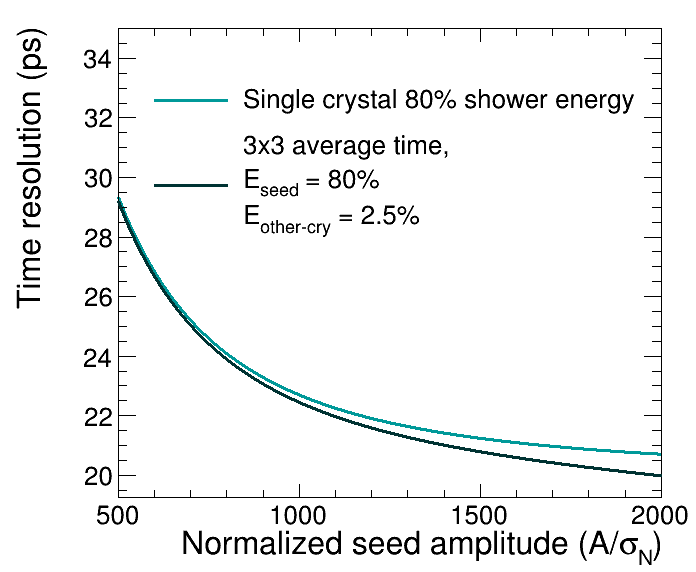

In [17]:
ECAL_t_res = ROOT.TFormula("ECAL_t_res", "sqrt(pow(1.07332e+04/x, 2)+20*20)")

time_res_singlecry = ROOT.TF1("time_res_singlecry", "ECAL_t_res(x)", 500, 2000)
time_res_singlecry.SetTitle(";Normalized seed amplitude (A/#sigma_{N}); Time resolution (ps)")
time_res_singlecry.SetLineColor(ROOT.kCyan+2)
time_res_singlecry.SetLineWidth(3)
time_res_singlecry.SetNpx(int(1e6))
time_res_singlecry.GetXaxis().SetNdivisions(507)
time_res_singlecry.GetYaxis().SetRangeUser(20, 35)

time_res_2cry = ROOT.TF1("time_res_2cry", "ECAL_t_res(x)*ECAL_t_res(x*0.1)/sqrt(pow(ECAL_t_res(x), 2)+pow(ECAL_t_res(x*0.1), 2))", 100, 2000)
time_res_2cry.SetLineColor(ROOT.kCyan+3)
time_res_2cry.SetLineWidth(3)
time_res_2cry.SetNpx(int(1e6))

time_res_3x3 = ROOT.TF1("time_res_3x3", "ECAL_t_res(x)*ECAL_t_res(x*0.025)/sqrt(8*pow(ECAL_t_res(x), 2)+pow(ECAL_t_res(x*0.025), 2))", 100, 2000)
time_res_3x3.SetLineColor(ROOT.kCyan+4)
time_res_3x3.SetLineWidth(3)
time_res_3x3.SetNpx(int(1e6))


c = ROOT.TCanvas()
time_res_singlecry.Draw()
#time_res_2cry.Draw("same")
time_res_3x3.Draw("same")
lg = ROOT.TLegend(0.2, 0.6, 0.8, 0.9)
lg.AddEntry(time_res_singlecry, 'Single crystal 80% shower energy', 'l')
lg.AddEntry(time_res_3x3, '#splitline{3x3 average time,}{#splitline{E_{seed} = 80%}{E_{other-cry} = 2.5%}}', 'l')
lg.Draw("same")
c.Draw()

In [2]:
import ROOT
import PyRDF
import json
import pandas as pd
from copy import deepcopy

ROOT.gROOT.Macro('../setStyle.C')
ROOT.gROOT.LoadMacro('../FPCanvasStyle.C')
#ROOT.gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')

Welcome to JupyROOT 6.18/00


0

In [93]:
runlist = pd.read_csv('data/energyscans18deg.csv', header=None, names=['run', 'energy', 'position', 'table_x', 'table_y', 'n_events'])
energies = ['150']
h4dfs = {}
h4t_list = {}
for E in energies:
    ###---Load trees using a TChain. Note RDataFrame accept a list of files too but doesn't deal with friend trees properly in that case, hence the workaround below
    h4t_list[E] = {}
    for run in runlist.loc[(runlist['position'].str.contains('C3')) & (abs(runlist['energy']-float(E))<10), 'run']:
        f = ROOT.TFile.Open('/eos/user/s/spigazzi/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v8/ECAL_H4_October2018_%d.root' % run)
        if f:
            if len(h4t_list[E])==0:
                h4t_list[E]['h4'] = ROOT.TChain('h4')
                for ft in f.Get("h4").GetListOfFriends():
                    h4t_list[E][ft.GetName()] = ROOT.TChain(ft.GetName())
                    h4t_list[E]['h4'].AddFriend(h4t_list[E][ft.GetName()])
            for name, t in h4t_list[E].items():
                t.Add('/eos/user/s/spigazzi/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v8/ECAL_H4_October2018_%d.root' % run)
            f.Close()
    
    channels_3x3 = ['B2', 'B3', 'B4',
                    'C2', 'C3', 'C4',
                    'D2', 'D3', 'D4']
    ch_x_pos = {
        'A' : -2,
        'B' : -1,
        'C' : 0,
        'D' : 1,
        'E' : 2
    }
 
    ch_y_pos = {
        '1' : -2,
        '2' : -1,
        '3' : 0,
        '4' : 1,
        '5' : 2
    }
    
    h4dfs[E] = ROOT.RDataFrame(h4t_list[E]['h4'])
    h4dfs[E] = h4dfs[E].Filter('n_tracks==1 && fabs(X[0]+5)<5 && fabs(Y[0]-4)< 5 && fit_ampl[MCP1]>100 && fit_ampl[MCP2]>100 && fabs(fit_time[MCP1]-fit_time[MCP2]-4.5)<1.5')
    for ch in ['MCP1', 'MCP2', 'VFE_CLK', 
               'A1', 'A2', 'A3',
               'B1', 'B2', 'B3', 'B4', 'B5',
               'C1', 'C2', 'C3', 'C4', 'C5',
               'D1', 'D2', 'D3', 'D4', 'D5',
               'E1', 'E2', 'E3']:
        h4dfs[E] = h4dfs[E].Define('time_%s'%ch, 'fit_time[%s]+time_calib[%s]'%(ch,ch))
        if ch not in ['MCP1', 'MCP2', 'VFE_CLK']:        
            h4dfs[E] = h4dfs[E].Define('ampl_%s'%ch, 'fit_ampl[%s]*ampl_calib[%s]'%(ch,ch))    
            h4dfs[E] = h4dfs[E].Define('dt_mcp1_%s'%ch, 'time_%s-time_MCP1+time_VFE_CLK-int((time_%s-time_MCP1+time_VFE_CLK)/6.238)*6.238'%(ch,ch))
            h4dfs[E] = h4dfs[E].Define('dt_mcp2_%s'%ch, 'time_%s-time_MCP2+time_VFE_CLK-int((time_%s-time_MCP2+time_VFE_CLK)/6.238)*6.238'%(ch,ch))
            h4dfs[E] = h4dfs[E].Define('ecal_r_%s'%ch, 'sqrt(pow(ecal_x-(%d*22), 2) + pow(ecal_y-(%d*22), 2))'%(ch_x_pos[ch[0]], ch_y_pos[ch[1]]))
            if ch != 'C3':
                if 'C' in ch:
                    distance = 'fabs(ecal_y - (%d))' % (ch_y_pos[ch[1]]*11)
                elif '3' in ch:
                    distance = 'fabs(ecal_x - (%d))' % (ch_x_pos[ch[0]]*11)
                else:
                    distance = 'sqrt(pow(ecal_x - (%d), 2)+pow(ecal_y - (%d), 2))' % (ch_x_pos[ch[0]]*11, ch_y_pos[ch[1]]*11)
            else:
                distance = 'ecal_r_%s' % ch
            h4dfs[E] = h4dfs[E].Define('shower_%s_dist'%ch, distance)
        else:
            ###---For the MCPs we need A/sigmaN as amplitude
            h4dfs[E] = h4dfs[E].Define('norm_ampl_%s'%ch, 'fit_ampl[%s]/b_rms[%s]'%(ch,ch))    

    h4dfs[E] = h4dfs[E].Define('dt_mcps', 'time_MCP1-time[TRG+LED]')            
    #h4dfs[E] = h4dfs[E].Define('ampl_seed', 'fit_ampl[seed]*ampl_calib[seed]')    
    #h4dfs[E] = h4dfs[E].Define('time_seed', 'fit_time[seed]-time_calib[seed]')    
    #h4dfs[E] = h4dfs[E].Define('dt_mcp1_seed', 'time_seed-time_MCP1+time_VFE_CLK-int((time_seed-time_MCP1+time_VFE_CLK)/6.238)*6.238')
    #h4dfs[E] = h4dfs[E].Define('dt_mcp2_seed', 'time_seed-time_MCP2+time_VFE_CLK-int((time_seed-time_MCP2+time_VFE_CLK)/6.238)*6.238')
    #h4dfs[E] = h4dfs[E].Define('trk_x', 'X[0]')
    #h4dfs[E] = h4dfs[E].Define('trk_y', 'Y[0]')

In [94]:
#h = {}
#for run in runlist.loc[(runlist['position'].str.contains('C3')) & (abs(runlist['energy']-150)<10), 'run']:
h = h4dfs['150'].Filter("ampl_C3>1000 && seed==C3").Profile1D(("","",10000,13350,13600,2.2,2.8), 'run', 'dt_mcp1_C3')

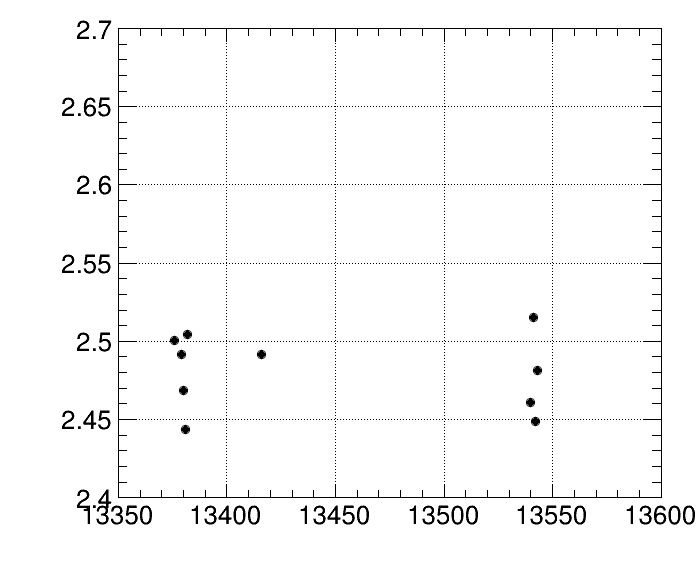

In [95]:
c = ROOT.TCanvas()
h.Draw("P")
h.GetXaxis().SetNdivisions(510)
h.GetYaxis().SetRangeUser(2.4,2.7)
c.SetGrid()
c.Draw()

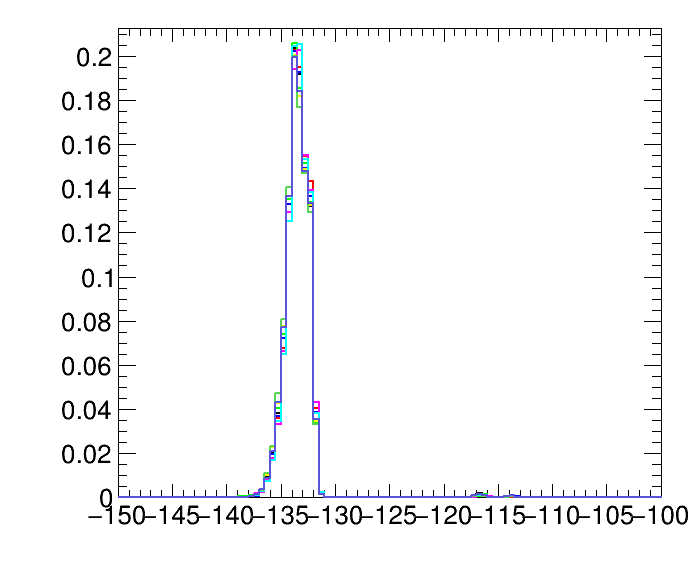

In [69]:
c = ROOT.TCanvas()
i = 0
lg = ROOT.TLegend()
for run,histo in h.items():
    histo.SetLineColor(i)
    i = i+1
    histo.DrawNormalized("same")    
    histo.SetName("%s"%run)
#c.BuildLegend(0.2, 0.2, 0.4, 0.9)
c.Draw()